Buisness Objective:
        
        build the model to predict the sales of the store.

In [1]:
#impoting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,accuracy_score

#importing models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,StackingRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing dataset
df = pd.read_csv('DS3_C6_S1_Regression_StoreSales_Data_Project.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.074402,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.064299,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
#shape
df.shape

(14204, 12)

In [4]:
#features
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [5]:
#datatypes
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [6]:
# null values
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

In Item_outlet_sales column containing 5681 null values out of 14204 rows.

In [7]:
#summary of the data
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,14204.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.793380,0.070301,141.004977,1997.830681,2181.288914
std,4.651716,0.048621,62.086938,8.371664,1706.499616
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,8.710000,0.033143,94.012000,1987.000000,834.247400
50%,12.600000,0.062347,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### EDA

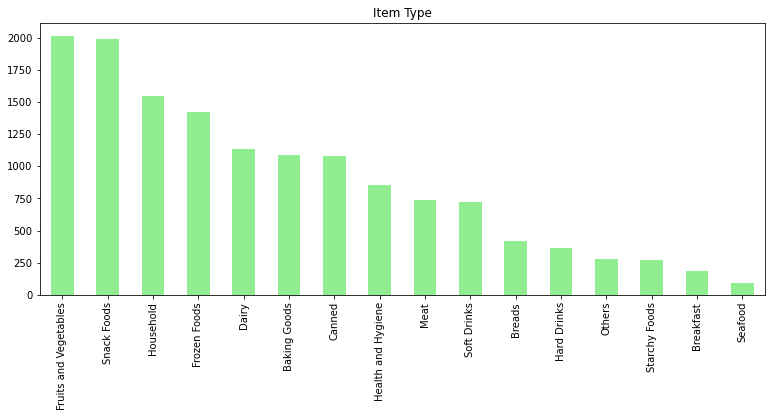

In [8]:
df['Item_Type'].value_counts().plot(kind='bar',figsize=(13,5),color='lightgreen')
plt.title('Item Type')
plt.show()

Most number of outlets are selling 'Fruits and vegetables' and least number oulets are selling food type 'seafoods'.

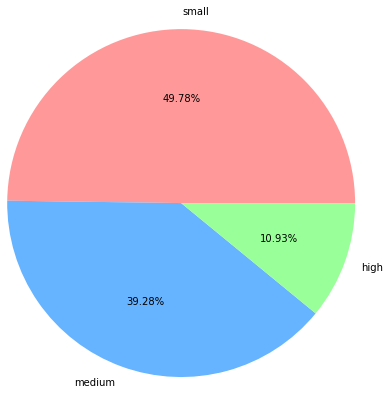

In [9]:
data  = df['Outlet_Size'].value_counts()
label = ['small','medium','high']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(data,labels=label,autopct='%.2f%%',colors=colors,radius=2)
plt.show()

Around 50% outlets are in small size.

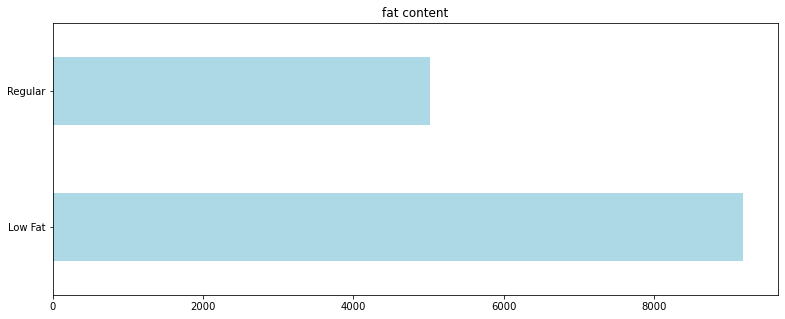

In [10]:
df['Item_Fat_Content'].value_counts().plot(kind='barh',figsize=(13,5),color='lightblue')
plt.title('fat content')
plt.show()

Most of the products are containing low fat.

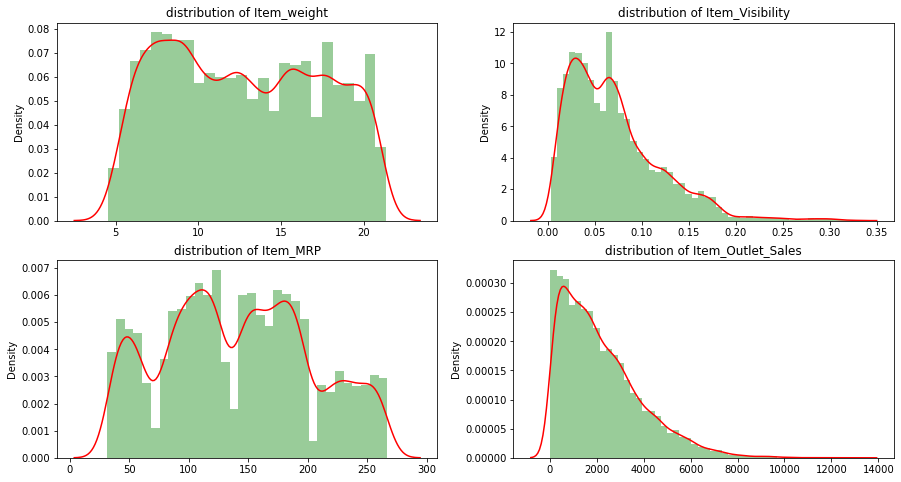

In [11]:
plt.subplots(figsize=(15,8))

plt.subplot(221)
sns.distplot(x=df['Item_Weight'],kde=True,kde_kws={'color':'r'},hist_kws={'color':'g'})
plt.title('distribution of Item_weight')

plt.subplot(222)
sns.distplot(x=df['Item_Visibility'],kde=True,kde_kws={'color':'r'},hist_kws={'color':'g'})
plt.title('distribution of Item_Visibility')

plt.subplot(223)
sns.distplot(x=df['Item_MRP'],kde=True,kde_kws={'color':'r'},hist_kws={'color':'g'})
plt.title('distribution of Item_MRP')

plt.subplot(224)
sns.distplot(x=df['Item_Outlet_Sales'],kde=True,kde_kws={'color':'r'},hist_kws={'color':'g'})
plt.title('distribution of Item_Outlet_Sales')

plt.show()

1.Item_outlet_sales and Item_visibility showing right skewness.

In [12]:
FEATURES = [col for col in df.columns if col not in ['Item_Outlet_Sales', 'Outlet_Identifier']]
cat_features = [col for col in FEATURES if df[col].nunique() < 10]
cont_features = [col for col in FEATURES if df[col].nunique() >= 10]

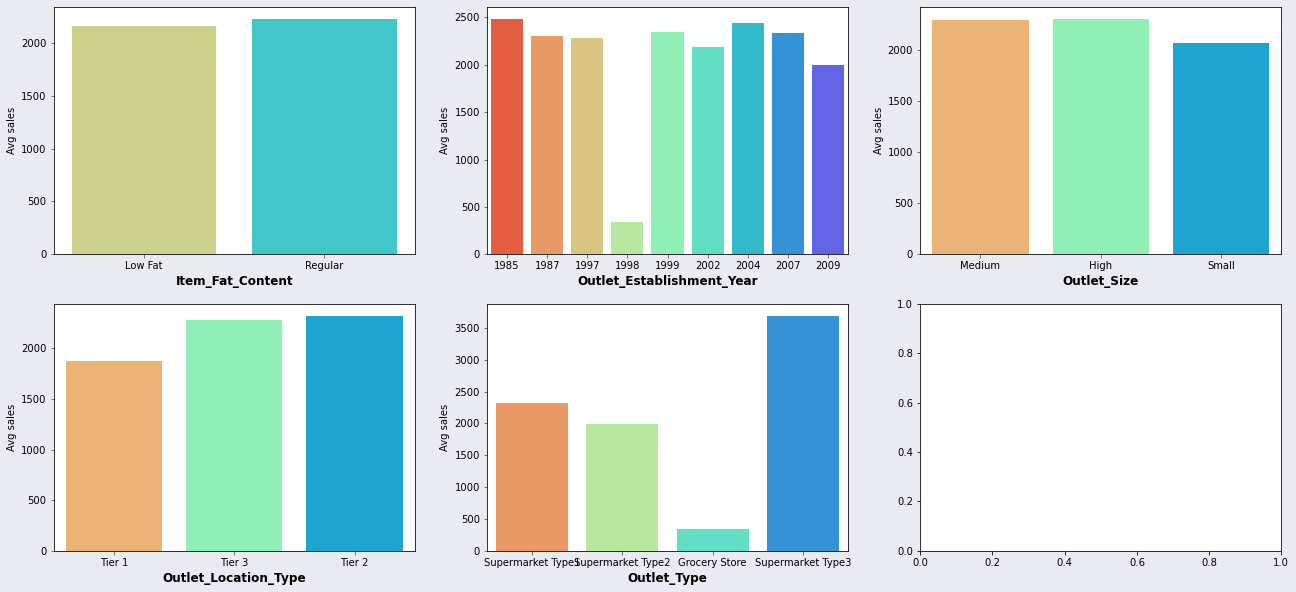

In [13]:
ncols = 3
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(22, 10), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        try:
            col = cat_features[r*ncols+c]
            sns.barplot(y=df['Item_Outlet_Sales'], x=df[col], ax=axes[r, c], palette='rainbow_r',ci=False)
            axes[r, c].set_ylabel('Avg sales')
            axes[r, c].set_xlabel(col, fontsize=12, fontweight='bold')
            axes[r, c].tick_params(labelsize=10, width=0.5)
            axes[r, c].xaxis.offsetText.set_fontsize(6)
            axes[r, c].yaxis.offsetText.set_fontsize(6)
        except:
            pass
plt.show()

--> Both type fat_content items sales was similarly same.

--> 1998 established oulets sales was very low.

--> Medium and small sized outlets contributing more to sales.

--> Tier2 locations contributing more to sales.

--> Supermarket type3 oulets are contributing more to sales.Grocery stores are contributing less to sales.


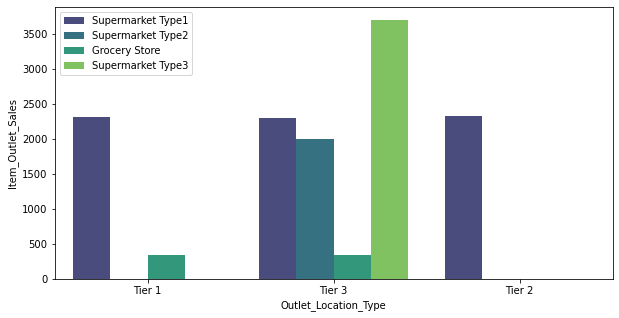

In [14]:
plt.figure(figsize=(10,5))
sns.barplot('Outlet_Location_Type','Item_Outlet_Sales',hue='Outlet_Type',data=df,palette='viridis',ci=False)
plt.legend()
plt.show()

--> Tier 3 location supermarket type3 outlets sales high among other oulets.

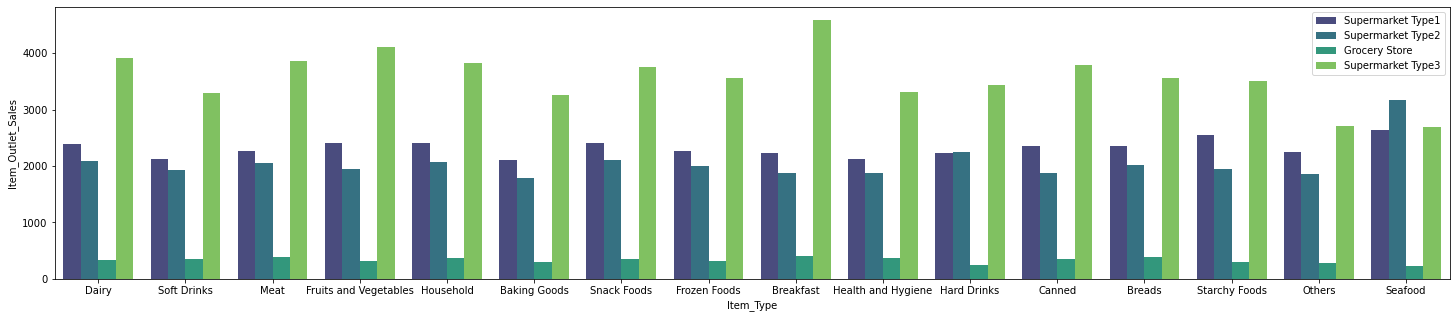

In [15]:
plt.figure(figsize=(25,5))
sns.barplot('Item_Type','Item_Outlet_Sales',hue='Outlet_Type',data=df,palette='viridis',ci=False)
plt.legend(loc='best')
plt.show()

--> Supermarket type3 sales high in all product except seafoods.

In [16]:
#by label encoder converting categorical features to numerical features

encoder = LabelEncoder()
for i in df.columns:
    if df[i].dtypes == "object":
        df[i] = encoder.fit_transform(df[i])

In [17]:
#scaling:
scale=MinMaxScaler()
df_scaled=pd.DataFrame(scale.fit_transform(df),columns=df.columns)
df_scaled

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0.100128,0.282525,0.0,0.038399,0.266667,0.927507,1.000000,0.583333,0.5,0.0,0.333333,0.283587
1,0.005135,0.081274,1.0,0.048346,0.933333,0.072068,0.333333,1.000000,0.5,1.0,0.666667,0.031419
2,0.424904,0.770765,0.0,0.040593,0.666667,0.468288,1.000000,0.583333,0.5,0.0,0.333333,0.158115
3,0.719512,0.871986,1.0,0.218055,0.400000,0.640093,0.000000,0.541667,0.5,1.0,0.000000,0.053555
4,0.832478,0.260494,0.0,0.186950,0.600000,0.095805,0.111111,0.083333,0.0,1.0,0.333333,0.073651
...,...,...,...,...,...,...,...,...,...,...,...,...
14199,0.149551,0.353974,1.0,0.030546,0.866667,0.467004,0.888889,0.500000,1.0,0.0,0.333333,NaN
14200,0.197689,0.181304,1.0,0.429216,1.000000,0.585126,0.333333,1.000000,0.5,1.0,0.666667,NaN
14201,0.915276,0.324204,0.0,0.215364,0.533333,0.371199,0.777778,0.708333,1.0,0.5,0.333333,NaN
14202,0.334403,0.639774,1.0,0.188211,0.200000,0.778154,0.222222,0.916667,1.0,0.5,0.333333,NaN


In [18]:
#correaltion matrix
df_scaled.corr().style.background_gradient(cmap='crest')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,1.000000,0.050768,-0.111079,-0.040769,-0.012048,0.010743,-0.001089,-0.002954,0.002209,-0.002473,-0.004532,0.002869
Item_Weight,0.050768,1.000000,-0.033737,-0.020472,0.031884,0.035751,0.003002,0.000247,0.000944,-0.001719,0.001913,0.013261
Item_Fat_Content,-0.111079,-0.033737,1.000000,0.048315,-0.147733,-0.004019,-0.001095,0.000137,-0.000827,0.001373,-0.000228,0.018719
Item_Visibility,-0.040769,-0.020472,0.048315,1.000000,-0.037821,-0.009144,-0.108731,-0.090833,0.026808,-0.020550,-0.172744,-0.135247
Item_Type,-0.012048,0.031884,-0.147733,-0.037821,1.000000,0.043948,0.001126,0.003061,-0.001080,0.002083,0.004305,0.017048
Item_MRP,0.010743,0.035751,-0.004019,-0.009144,0.043948,1.000000,-0.000555,0.000141,-0.001305,0.000838,0.000136,0.567574
Outlet_Identifier,-0.001089,0.003002,-0.001095,-0.108731,0.001126,-0.000555,1.000000,0.079047,0.423623,-0.716151,0.099899,0.162325
Outlet_Establishment_Year,-0.002954,0.000247,0.000137,-0.090833,0.003061,0.000141,0.079047,1.000000,0.428387,-0.089328,-0.122519,-0.049135
Outlet_Size,0.002209,0.000944,-0.000827,0.026808,-0.001080,-0.001305,0.423623,0.428387,1.000000,-0.590677,-0.260496,-0.060517
Outlet_Location_Type,-0.002473,-0.001719,0.001373,-0.020550,0.002083,0.000838,-0.716151,-0.089328,-0.590677,1.000000,0.467251,0.089367


Removing 'Item_Identifier' column,beacuse of less correation with our target column.And removing Outlet identifier also,beacuse of less correlation with our target feature and highly correlated with other features.

In [19]:
#dropping 'Item_Identifier','Outlet_Identifier'
df_scaled = df_scaled.drop(columns=['Item_Identifier','Outlet_Identifier'],axis=1)

In [20]:
# extracting null values from sales for prediction
index = df_scaled[df_scaled['Item_Outlet_Sales'].isnull()].index
set_to_predict = df_scaled.loc[index]

In [21]:
#deleting null value index for modelling
data = df_scaled.drop(index,axis=0)

In [22]:
#independent and dependent columns
X = data.drop(columns=['Item_Outlet_Sales'],axis=1)
y = data['Item_Outlet_Sales']


x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=50)

In [23]:
#Creating list of models and another list mapped to their names

models=[KNeighborsRegressor(),LinearRegression(),DecisionTreeRegressor(),
       RandomForestRegressor(),AdaBoostRegressor()]

names=['KNeighborsRegressor','LinearRegression','DecisionTreeRegressor',
       'RandomForestRegressor','AdaBoostRegressor']

In [24]:
def createmodels(model_list,independent,dependent,n):
    xtrain,xtest,ytrain,ytest=train_test_split(independent,dependent,test_size=0.2,random_state=100)
    name=[]
    meanabs=[]
    meansqd=[]
    rootmeansqd=[]
    r2=[]
    mcv=[]
    
    #Creating models
    for i,model in enumerate(model_list):
        model.fit(xtrain,ytrain)
        p=model.predict(xtest)
        score=cross_val_score(model,independent,dependent,cv=10)
        
        #Calculating scores of the model and appending them to a list
        name.append(n[i])
        meanabs.append(np.round(mean_absolute_error(p,ytest),4))
        meansqd.append(np.round(mean_squared_error(p,ytest),4))
        rootmeansqd.append(np.round(np.sqrt(mean_squared_error(p,ytest)),4))
        r2.append(np.round(r2_score(p,ytest),4)*100)
        mcv.append(np.round(np.mean(score),4)*100)
    
    #Creating Dataframe
    data=pd.DataFrame()
    data['Model']=name
    data['Mean Absolute Error']=meanabs
    data['Mean Squared Error']=meansqd
    data['Root Mean Squared Error']=rootmeansqd
    data['R2 Score']=r2
    data['Mean of Cross validaton Score']=mcv
    data.set_index('Model',inplace = True)
    return data

In [25]:
createmodels(models,X,y,names)

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2 Score,Mean of Cross validaton Score
Model,,,,,
KNeighborsRegressor,0.0635,0.0081,0.0899,22.58,51.47
LinearRegression,0.0711,0.0089,0.0943,-4.82,49.78
DecisionTreeRegressor,0.0830,0.0143,0.1195,19.94,19.45
RandomForestRegressor,0.0621,0.0077,0.0876,32.56,55.46
AdaBoostRegressor,0.0867,0.0112,0.1058,-53.61,47.42


With default hyper parameter comparing all the models evaluation metrics.RandomForestRegressor has highest R2 score and cross validation score has also high. 

In [26]:
# Stacking
def stacking():
    #base models
    base_models = list()
    base_models.append(('lr',LinearRegression()))
    base_models.append(('KNR',KNeighborsRegressor()))
    base_models.append(('DTR',DecisionTreeRegressor()))
    base_models.append(('SVR',SVR()))
    #meta_model
    meta = LinearRegression()
    model = StackingRegressor(estimators=base_models, final_estimator=meta, cv=5)
    return model
    

In [27]:
#stacke model cross val score
model  = stacking()

score = cross_val_score(model, X, y, scoring='r2', cv=10, n_jobs=-1, error_score='raise')
print("Stacking Mean Cross validation score: ",np.mean(score))

Stacking Mean Cross validation score:  0.5774892184103242


Stacked model mean cross vaildation score high,compared to all other models.so,our final model is stacked model .

#### Final model -- Ensemble Stacked model

In [28]:
# model training
model4 = stacking()
model4.fit(x_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('lr', LinearRegression()),
                              ('KNR', KNeighborsRegressor()),
                              ('DTR', DecisionTreeRegressor()),
                              ('SVR', SVR())],
                  final_estimator=LinearRegression())

In [29]:
#Accuracy on train dataset
train_accu1=model4.score(x_train,y_train)
print("accuracy of model on training dataset: ",train_accu1)

accuracy of model on training dataset:  0.6469226929565062


In [30]:
#Accuracy on test dataset
test_accu1=model4.score(x_test,y_test)
print("accuracy of model on test dataset: ",test_accu1)

accuracy of model on test dataset:  0.5870876374428449


In [31]:
#prediction
ypred1=model4.predict(x_test)

In [32]:
#RMSE,MSE
RMSE1=mean_squared_error(y_test,ypred1,squared=False)
MSE1=mean_squared_error(y_test,ypred1)
print("RMSE: ",RMSE1)
print("MSE: ",MSE1)

RMSE:  0.08323238858959536
MSE:  0.0069276305103294035


In [33]:
pd.DataFrame({'model':['Stacked model'],
              "RMSE":RMSE1,
              "MSE":MSE1,
              'accuracy':test_accu1
    
})

,model,RMSE,MSE,accuracy
0,Stacked model,0.083232,0.006928,0.587088


In [34]:
predset = set_to_predict.drop(['Item_Outlet_Sales'],axis=1)

In [35]:
#predicting null values
predicted = model4.predict(predset)

In [36]:
sales_predicted = pd.DataFrame(predicted,columns=['sales_predicted'])
sales_predicted

,sales_predicted
0,0.121510
1,0.107524
2,0.099262
3,0.178629
4,0.460007
...,...
5676,0.165979
5677,0.207309
5678,0.145010
5679,0.301091


These are the values predicted by ensemble stacked model with around 60% accuracy.